# ** IMPORT PACKAGES: **

In [1]:
# python peripherals
import random
import os
import sys
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.networks import DeepSignatureCurvatureNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing
from deep_signature.linalg import euclidean_transform
from deep_signature.linalg import affine_transform

# common
from common import settings
from common import utils as common_utils

# notebooks
from notebooks.utils import utils as notebook_utils

# ipython
from IPython.display import display, HTML

# ** GLOBAL SETTINGS: **

In [2]:
curvature_type = 'affine'
plt.style.use("dark_background")

if curvature_type == 'euclidean':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_euclidean_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_euclidean_curvature_tuplets_results_dir_path
elif curvature_type == 'affine':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_affine_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_affine_curvature_tuplets_results_dir_path

# ** SANITY CHECK - CURVES: **

In [ ]:
curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
limit = 10
color_map = plt.get_cmap('rainbow', limit)
for i, curve in enumerate(curves[:limit]): 
    fig, ax = plt.subplots(1, 1, figsize=(80,40))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(30)
    ax.axis('equal')
    notebook_utils.plot_curve(ax=ax, curve=curve, linewidth=5)
    plt.show()

# ** SANITY CHECK - DATASET PAIRS **

In [ ]:
dataset = DeepSignatureTupletsDataset()
dataset.load_dataset(dir_path=level_curves_curvature_tuplets_dir_path)
dataset_size = len(dataset)
indices = list(range(dataset_size))
# numpy.random.shuffle(indices)
sampler = SequentialSampler(indices)
data_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

display(HTML('<h3>Random sample of tuplets:</h3>'))
for tuplet_index, data in enumerate(data_loader, 0):
    if tuplet_index == 5:
        break

    curve1 = torch.squeeze(torch.squeeze(data['input'])[0])
    curve2 = torch.squeeze(torch.squeeze(data['input'])[1])
    curve3 = torch.squeeze(torch.squeeze(data['input'])[2])
    # curve4 = torch.squeeze(torch.squeeze(data['input'])[3])

    display(HTML(f'<h3>Sample #{tuplet_index}:</h3>'))

    curve1 = curve1.cpu().numpy()
    curve2 = curve2.cpu().numpy()
    curve3 = curve3.cpu().numpy()
    # curve4 = curve4.cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.axis('equal')

    notebook_utils.plot_sample(
        ax=ax, 
        sample=curve1, 
        point_size=50,
        color='lightcoral',
        zorder=50)

    notebook_utils.plot_sample(
        ax=ax, 
        sample=curve2, 
        point_size=50,
        color='skyblue',
        zorder=50)

    notebook_utils.plot_sample(
        ax=ax, 
        sample=curve3, 
        point_size=50,
        color='springgreen',
        zorder=50)

    # plot_sample(
    #     ax=ax, 
    #     sample=curve4, 
    #     point_size=50,
    #     color='gold',
    #     zorder=50)

    notebook_utils.plot_sample(ax, numpy.array([[0,0]]), point_size=50, alpha=1, color='white', zorder=100)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
    
    plt.show()

# ** TRAIN/VALIDATION LOSS **

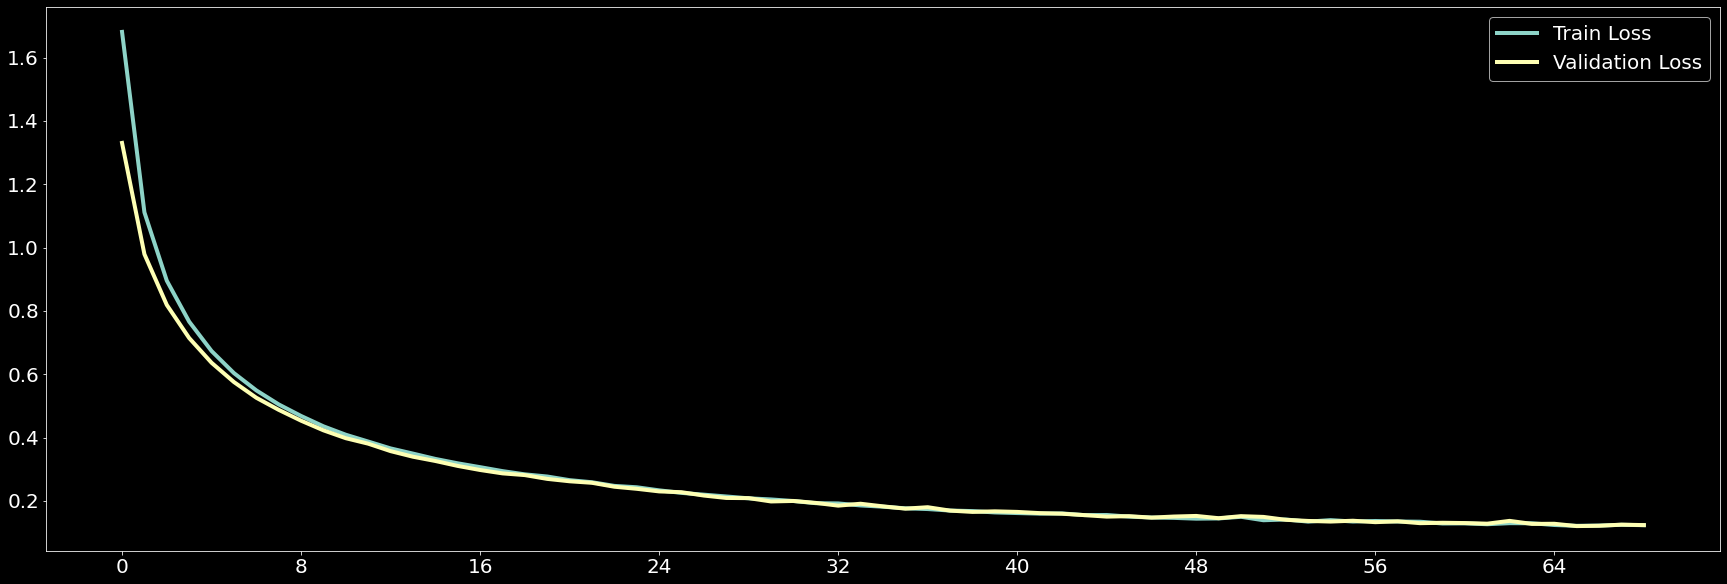

In [11]:
# results_file_path = os.path.normpath(os.path.join(results_base_dir_path, 'results.npy'))
# all_subdirs = all_subdirs_of(level_curves_curvature_tuplets_results_dir_path)
# latest_subdir = os.path.normpath(max(all_subdirs, key=os.path.getmtime))
latest_subdir = common_utils.get_latest_subdirectory(level_curves_curvature_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
train_loss_array = results['train_loss_array']
validation_loss_array = results['validation_loss_array']
epochs_list = numpy.array(range(len(train_loss_array)))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)
plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

# ** TEST MODEL **

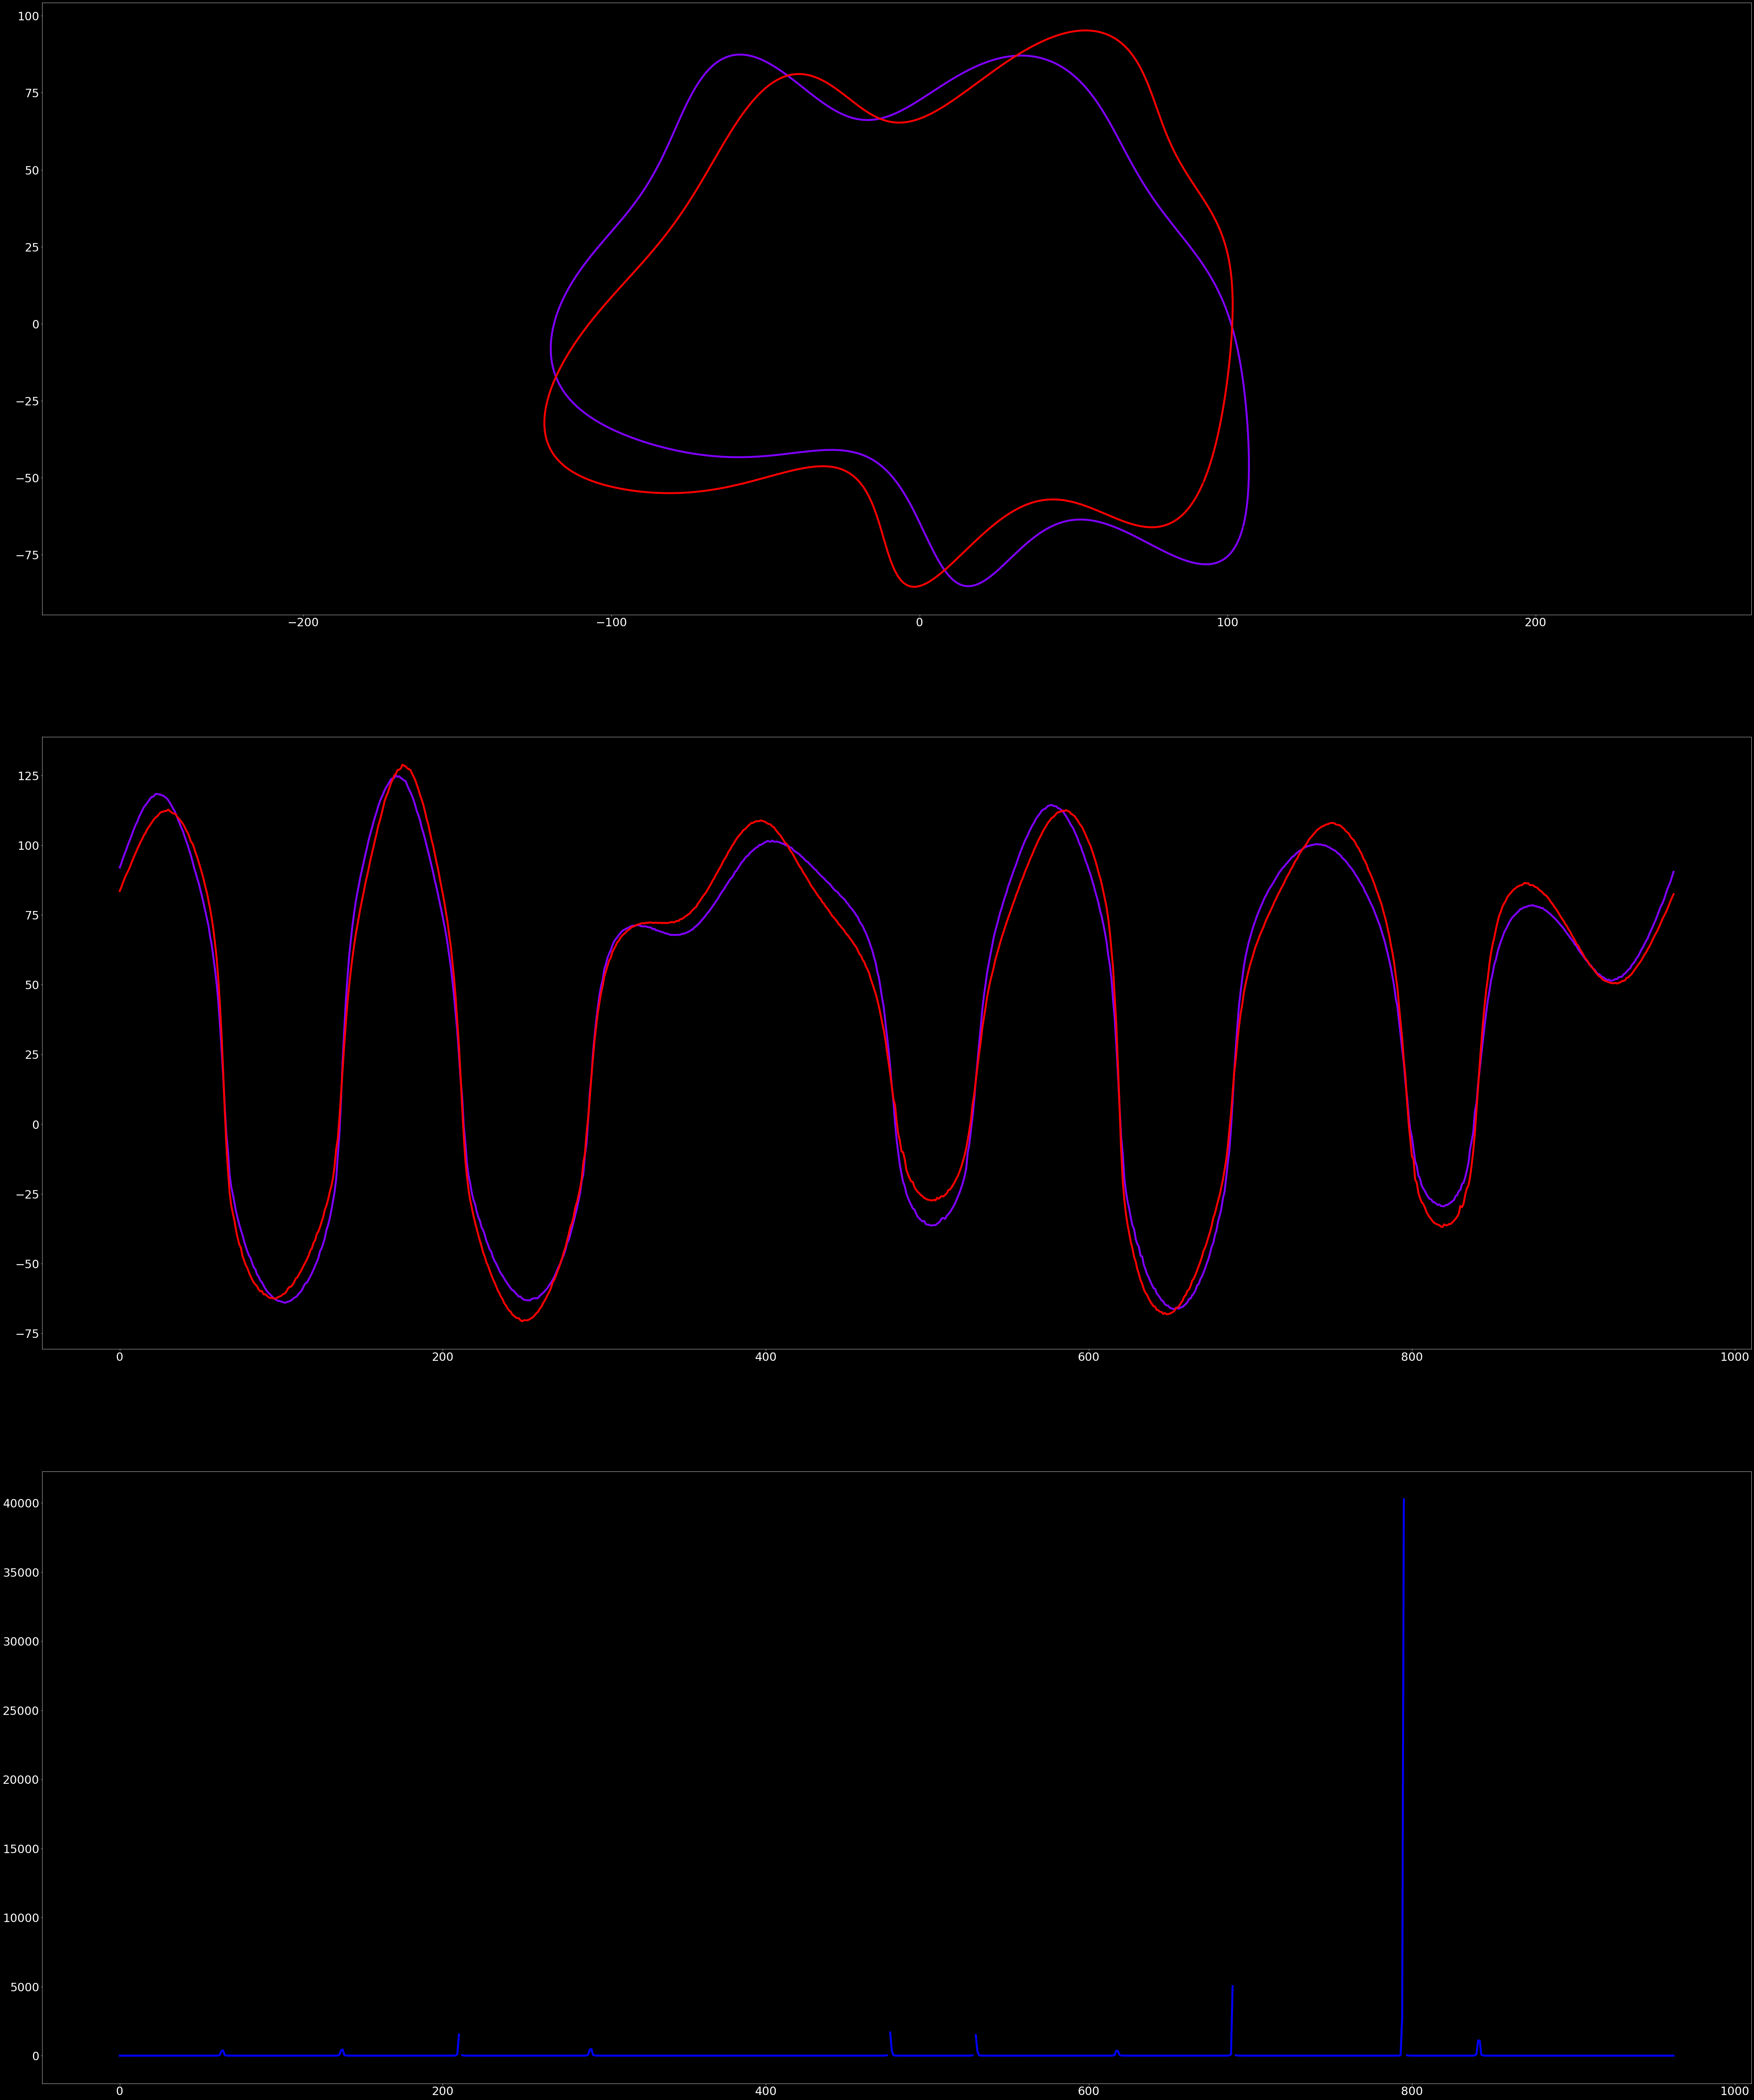

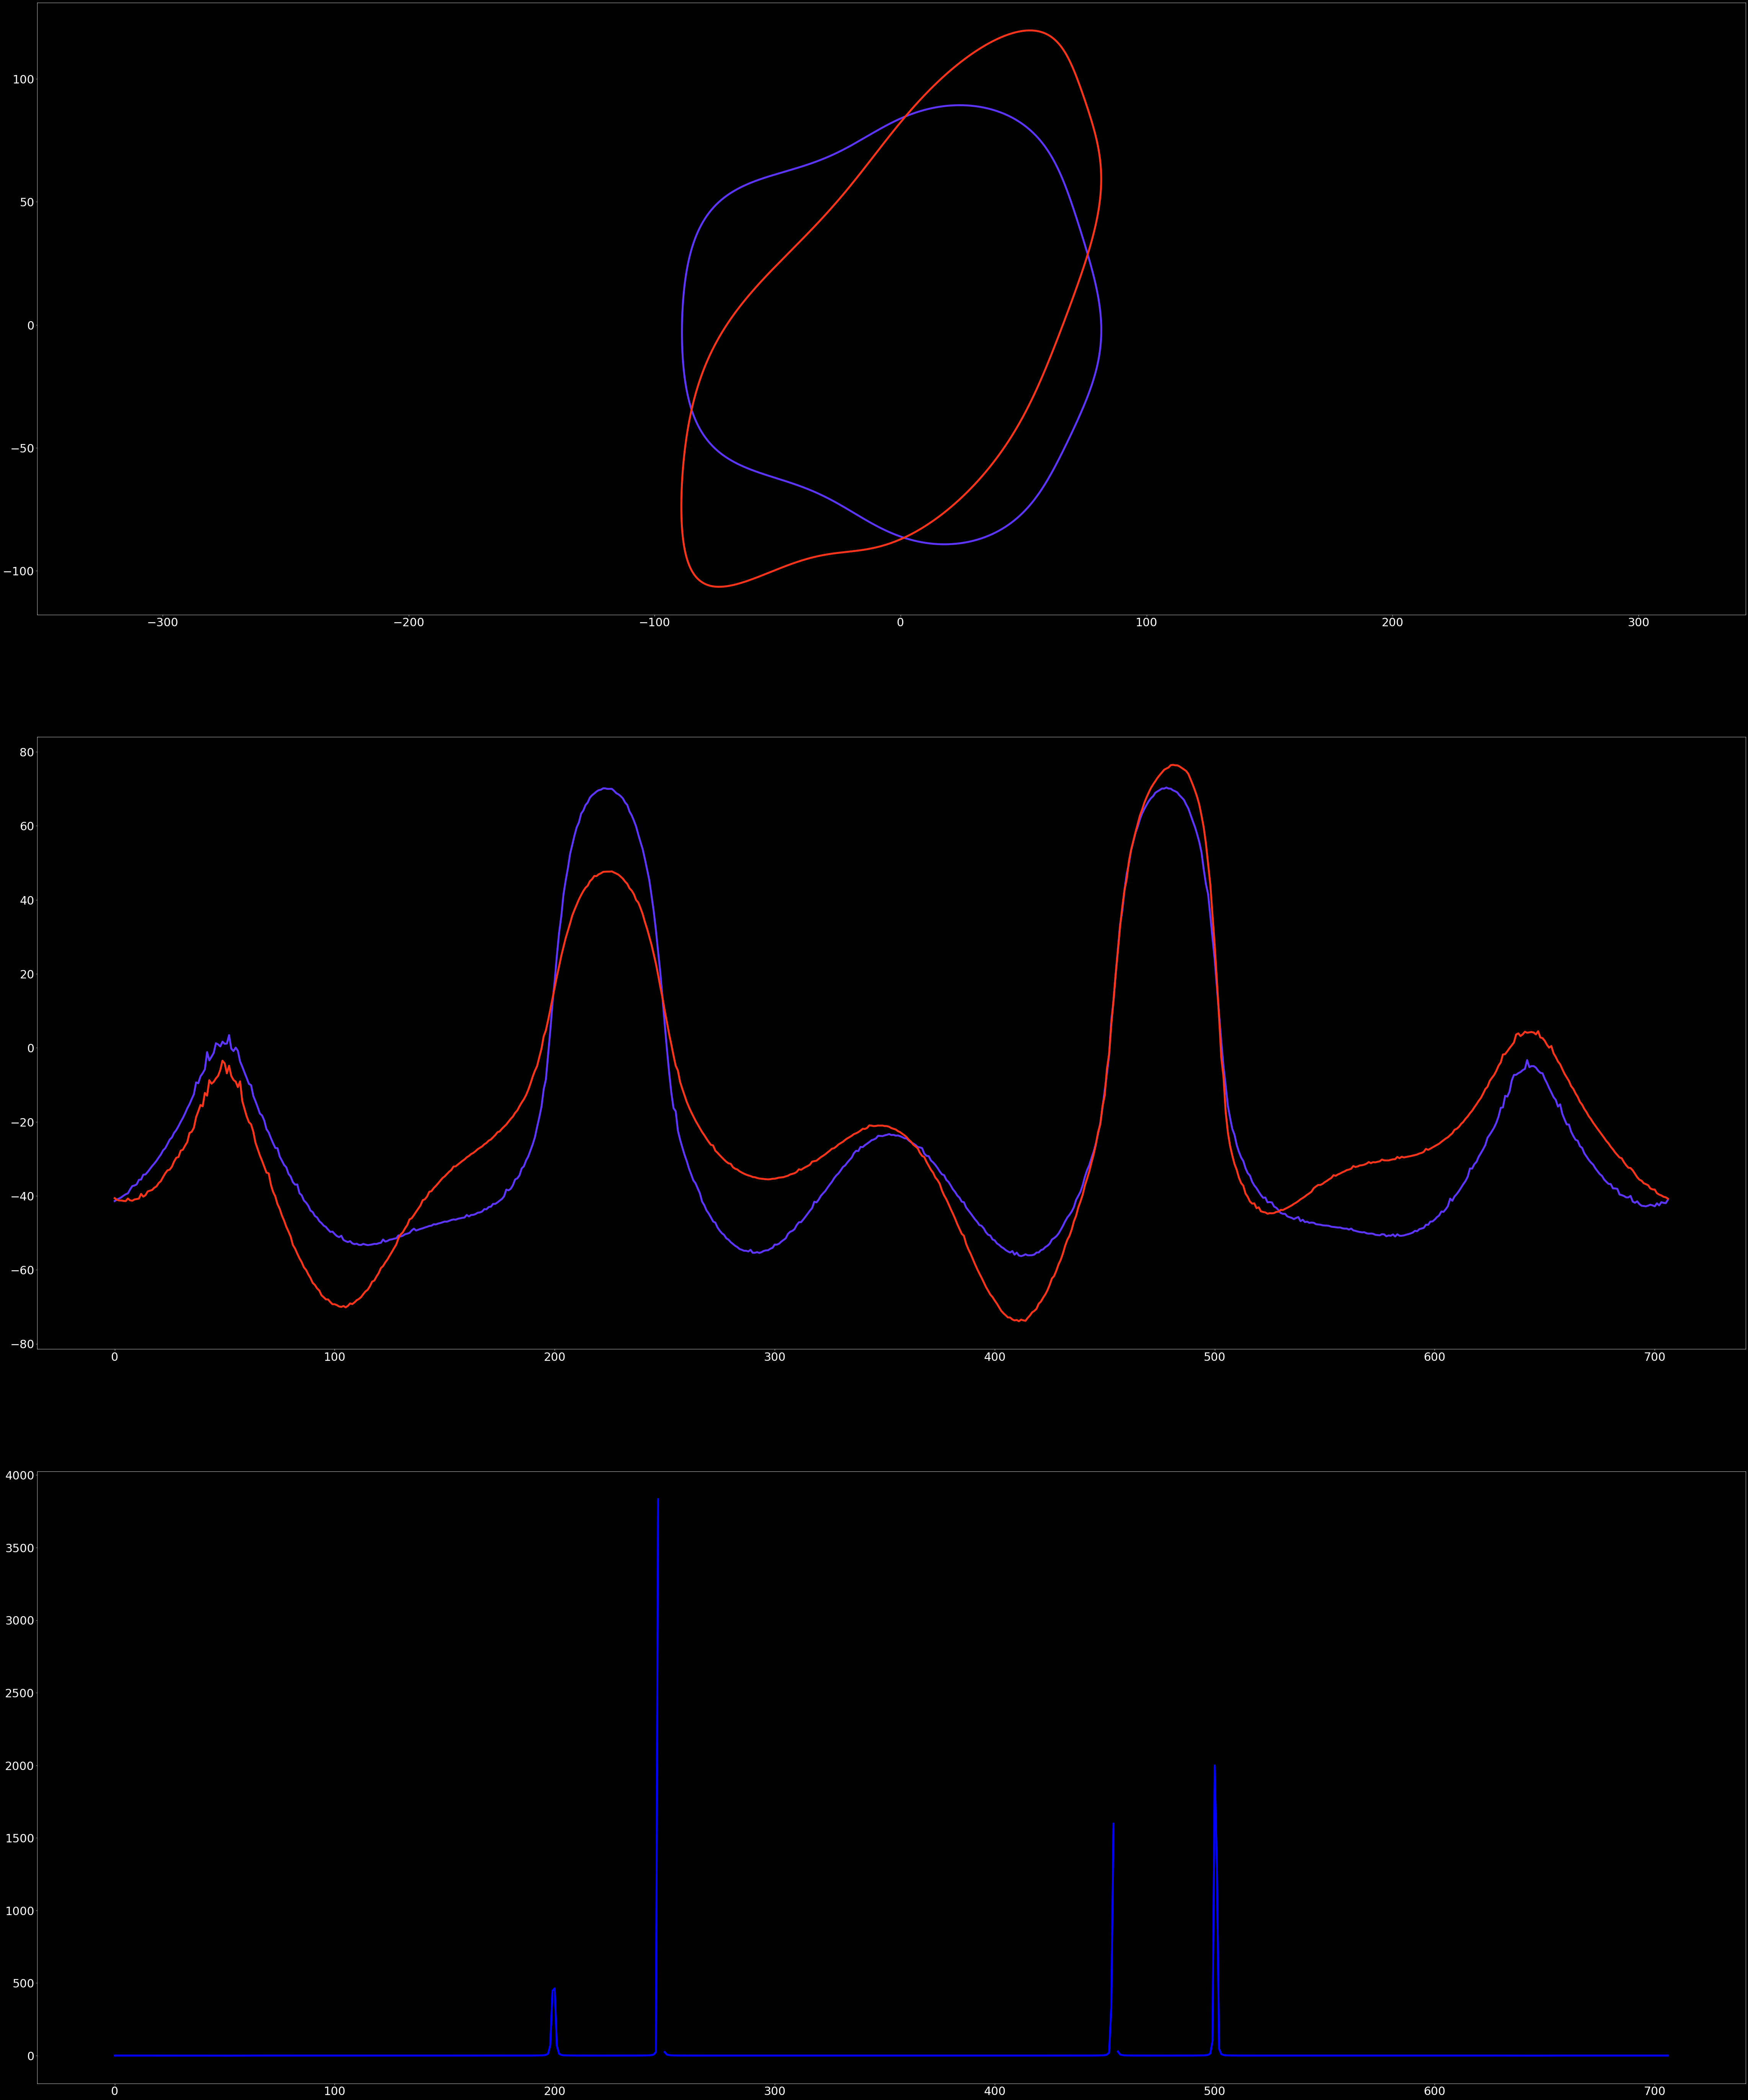

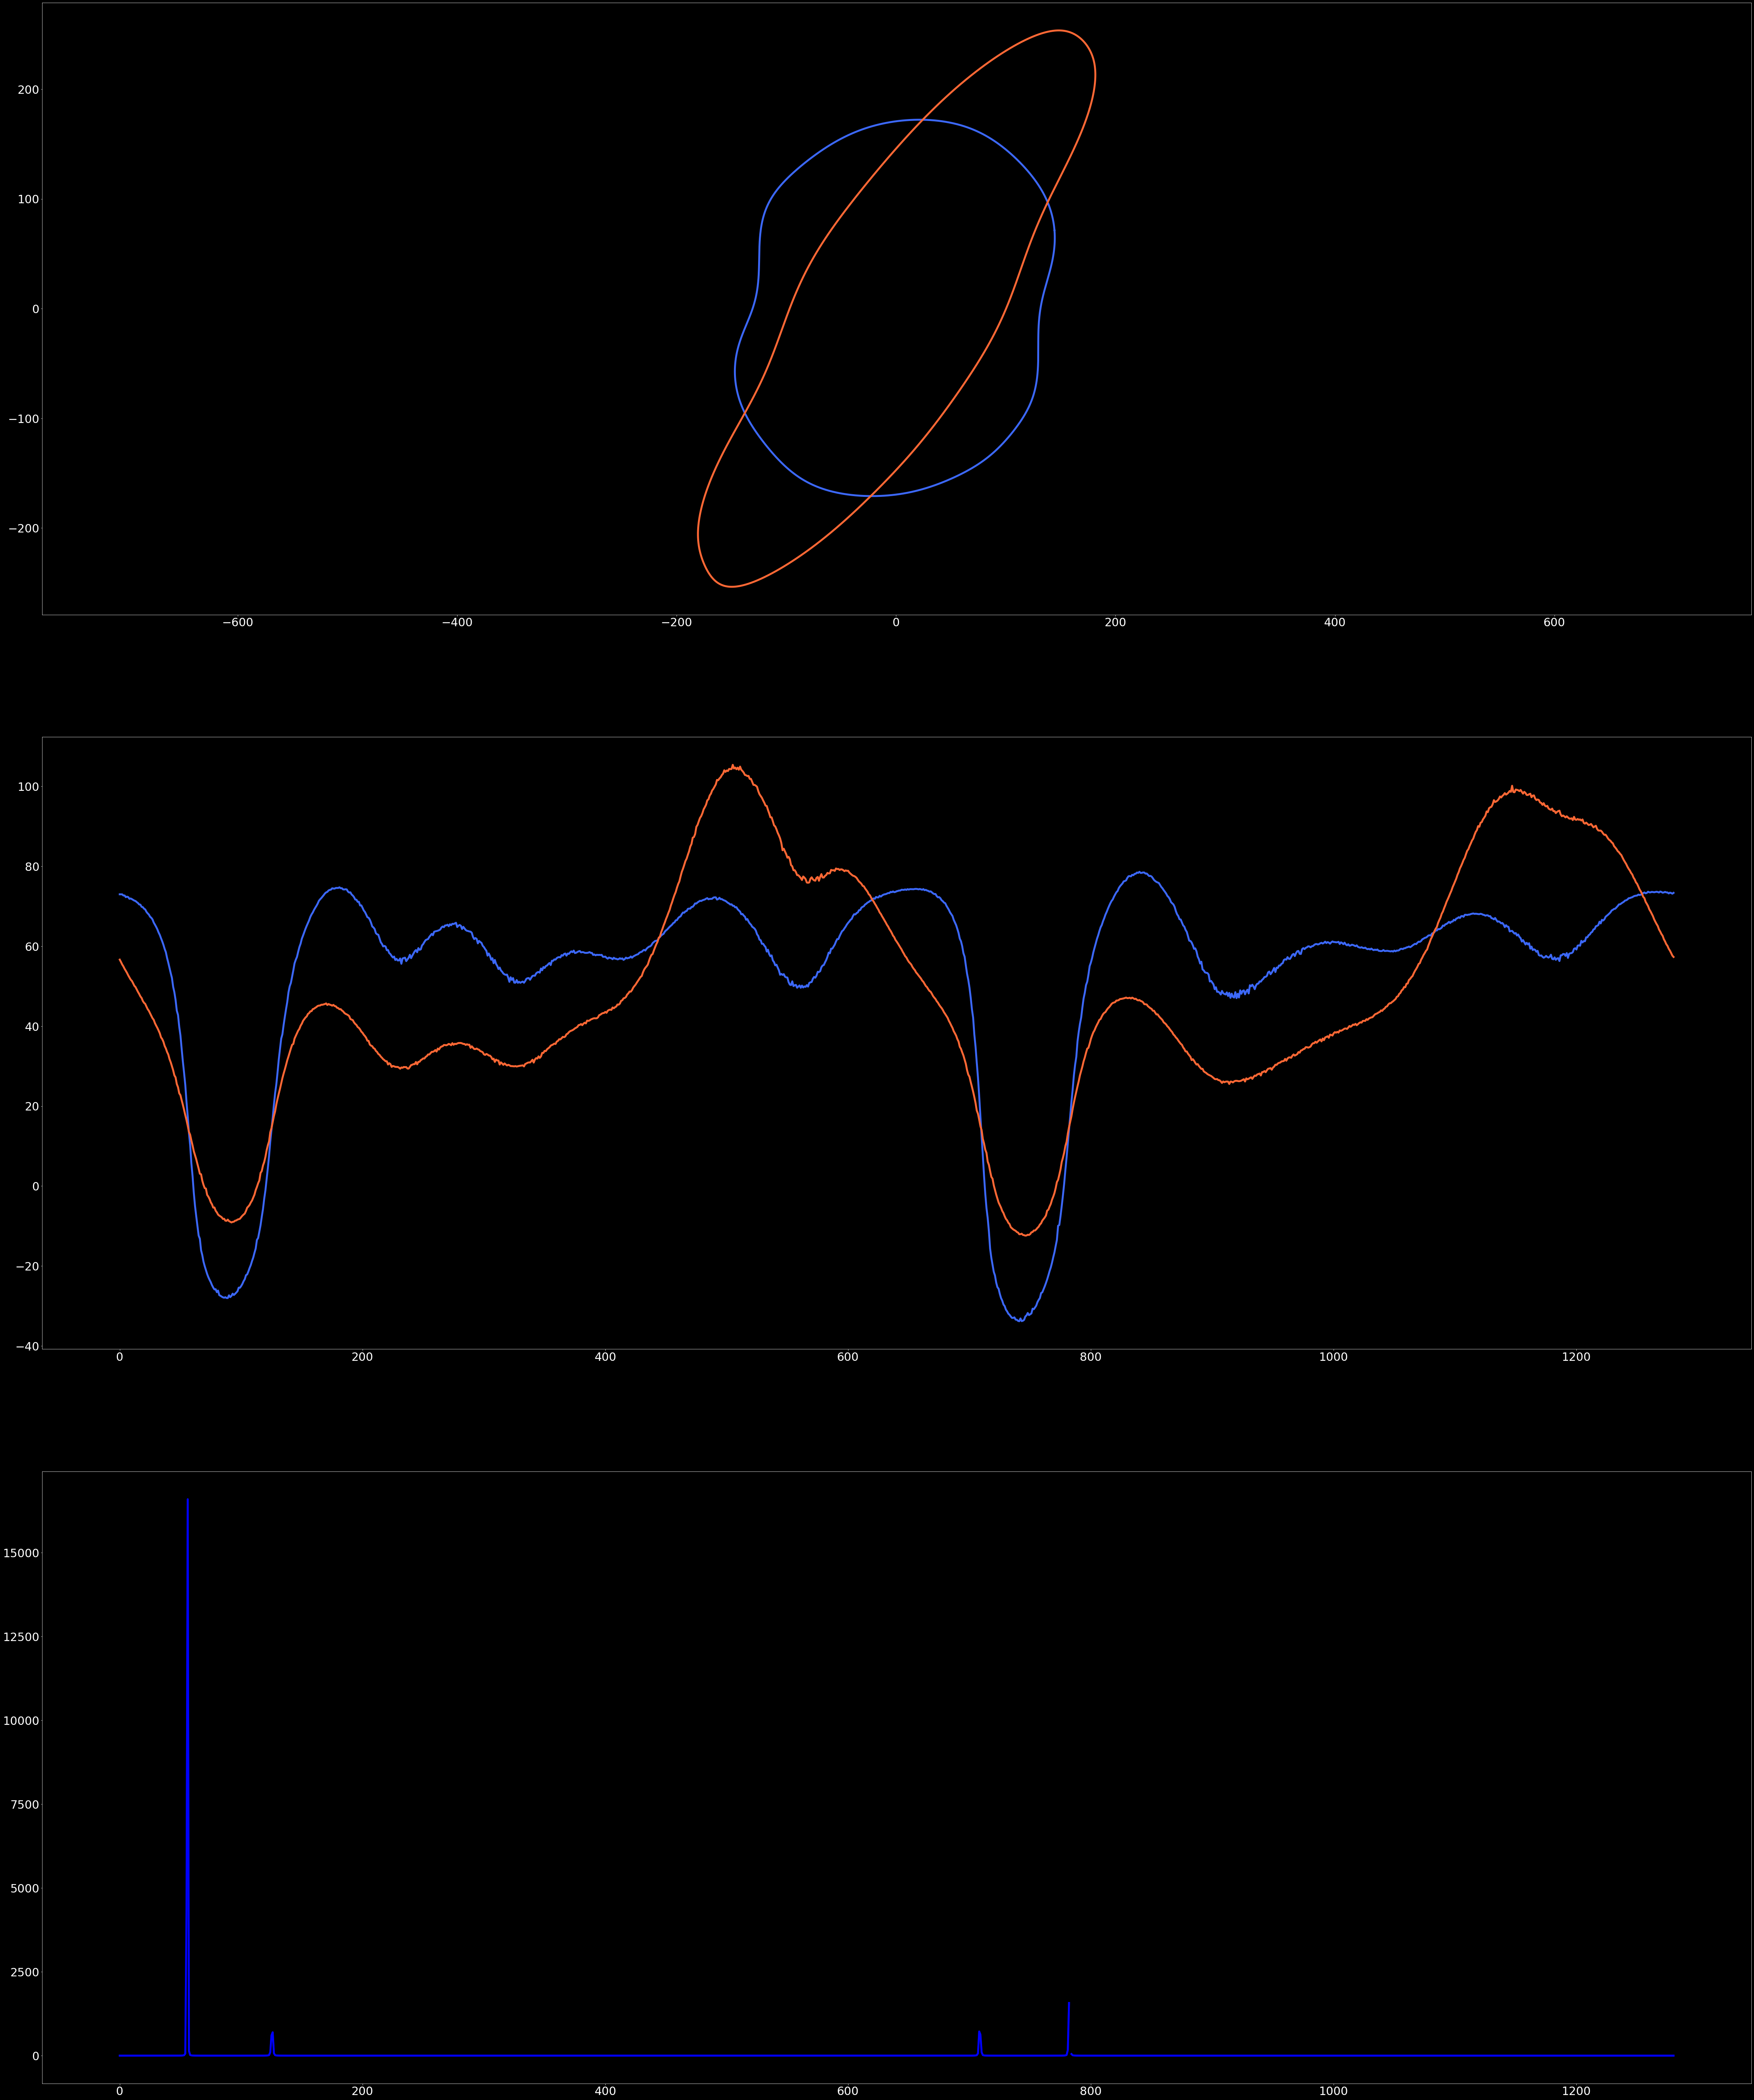

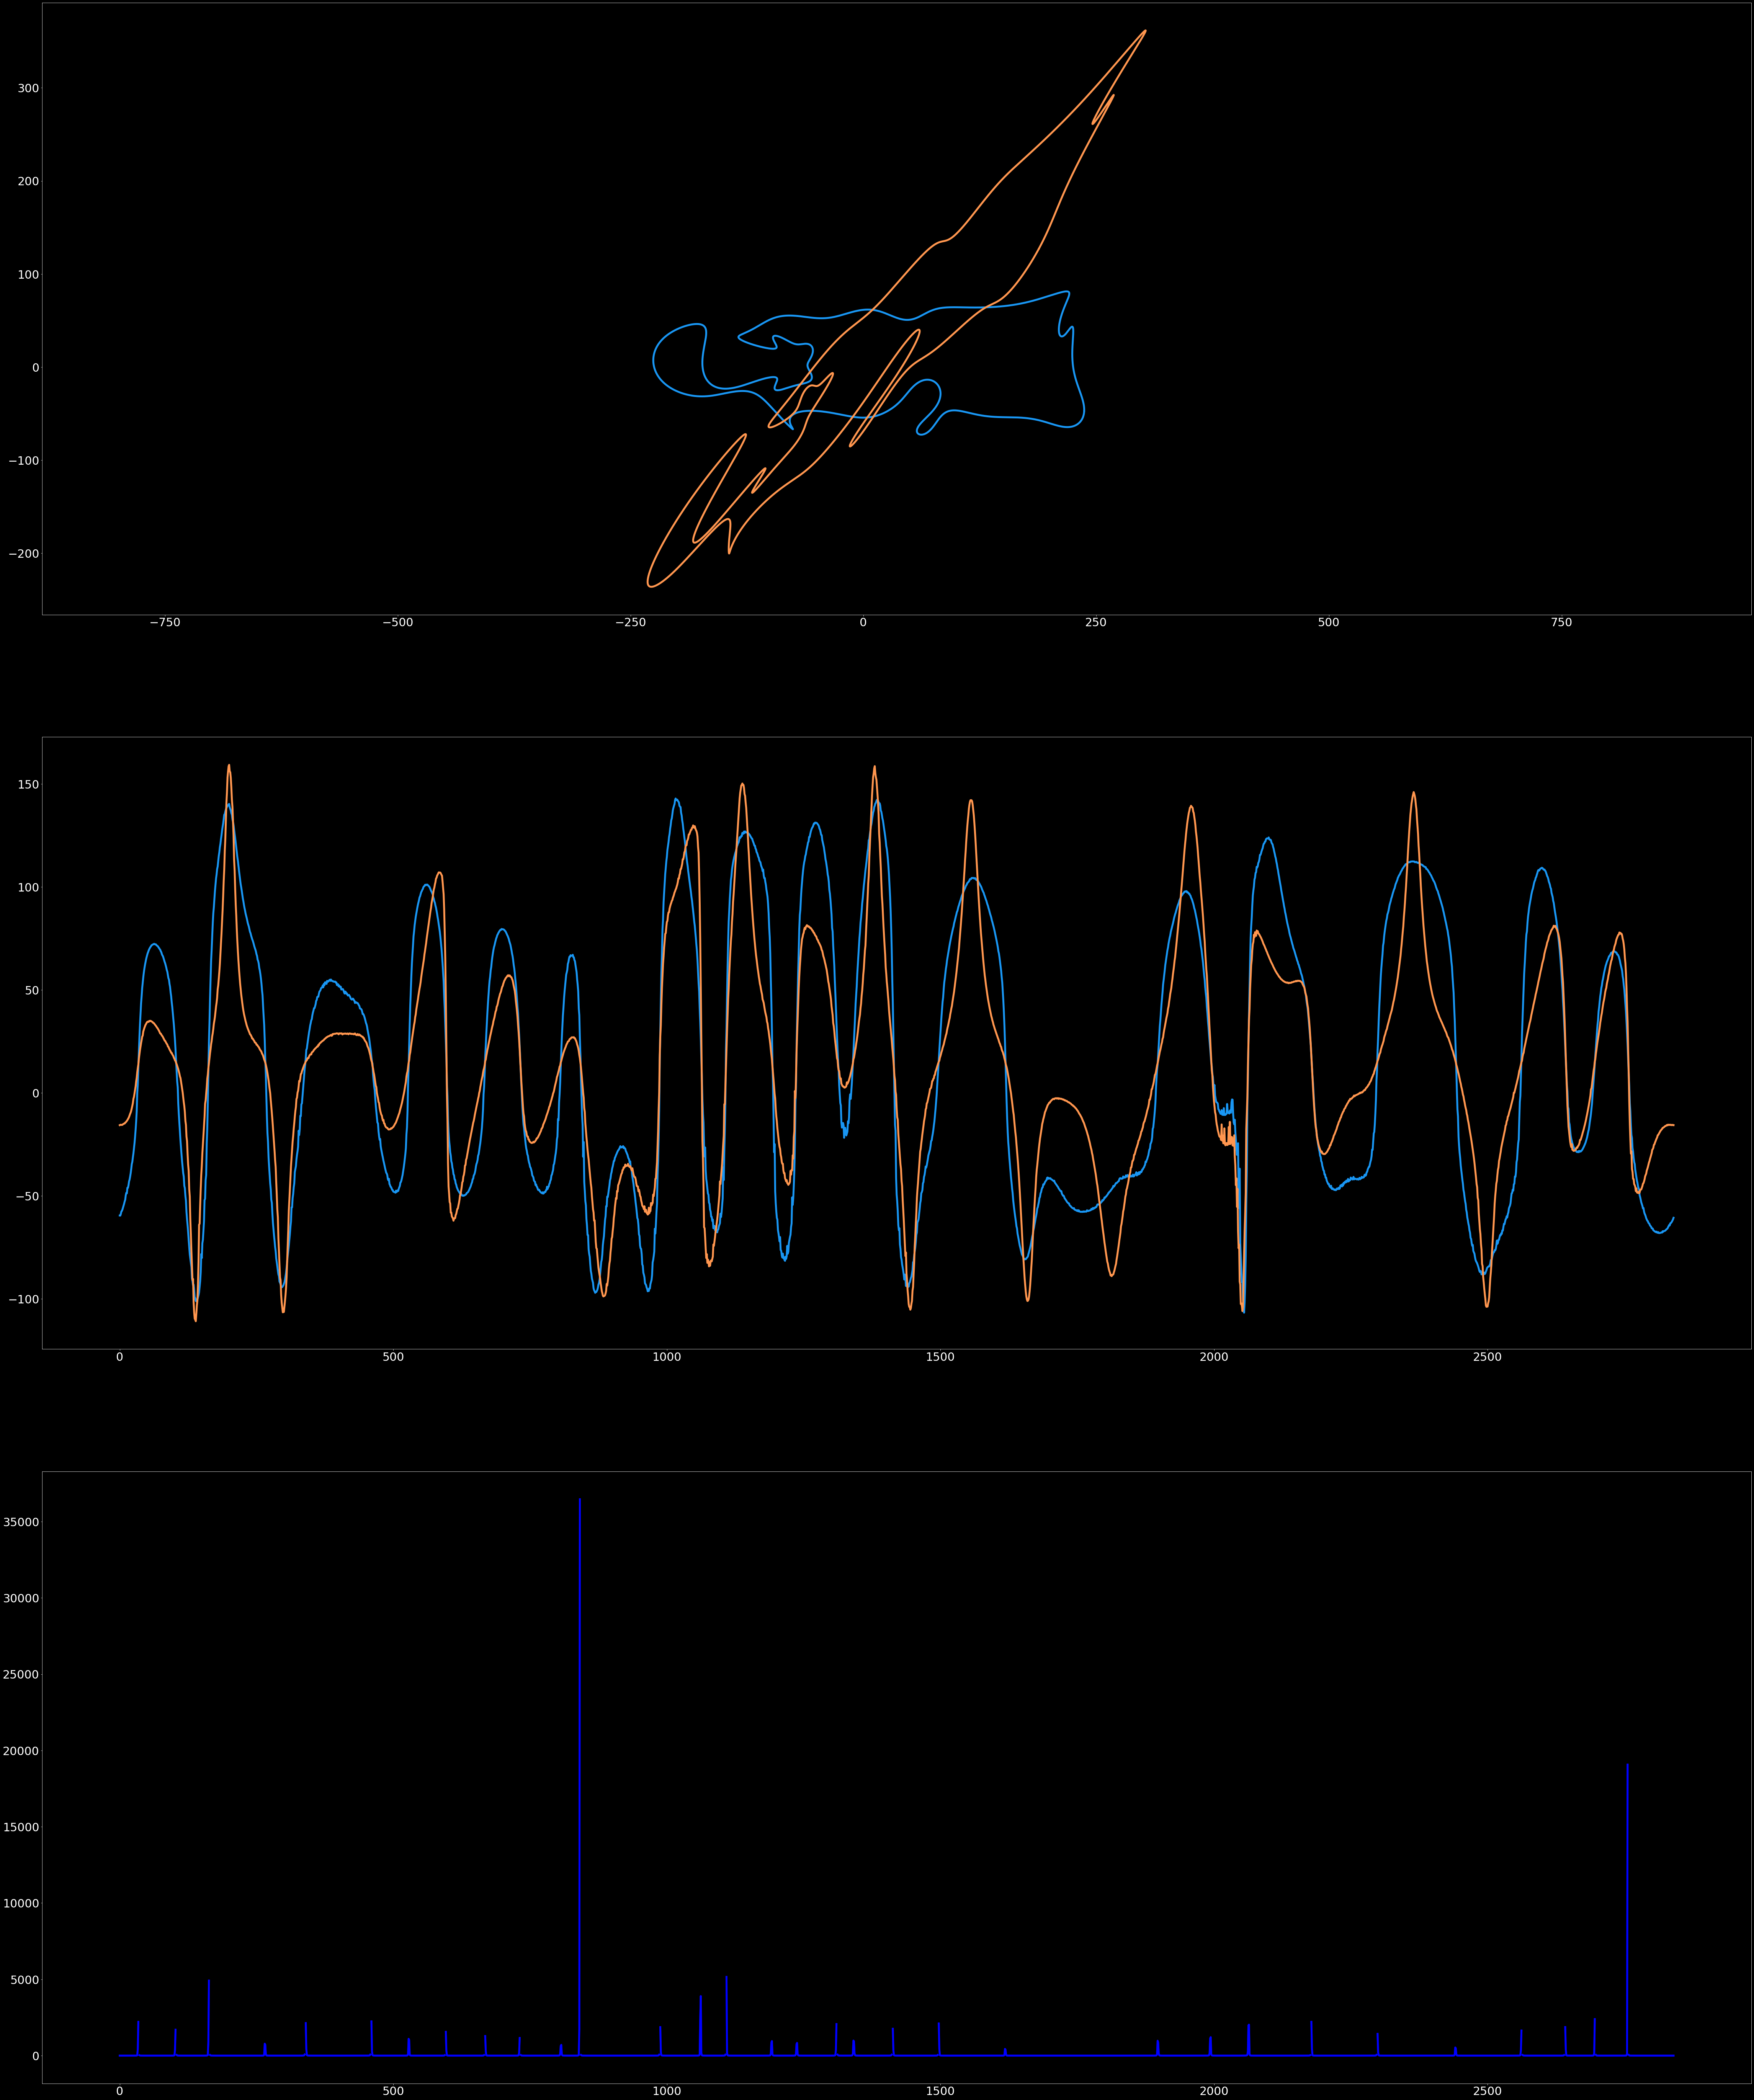

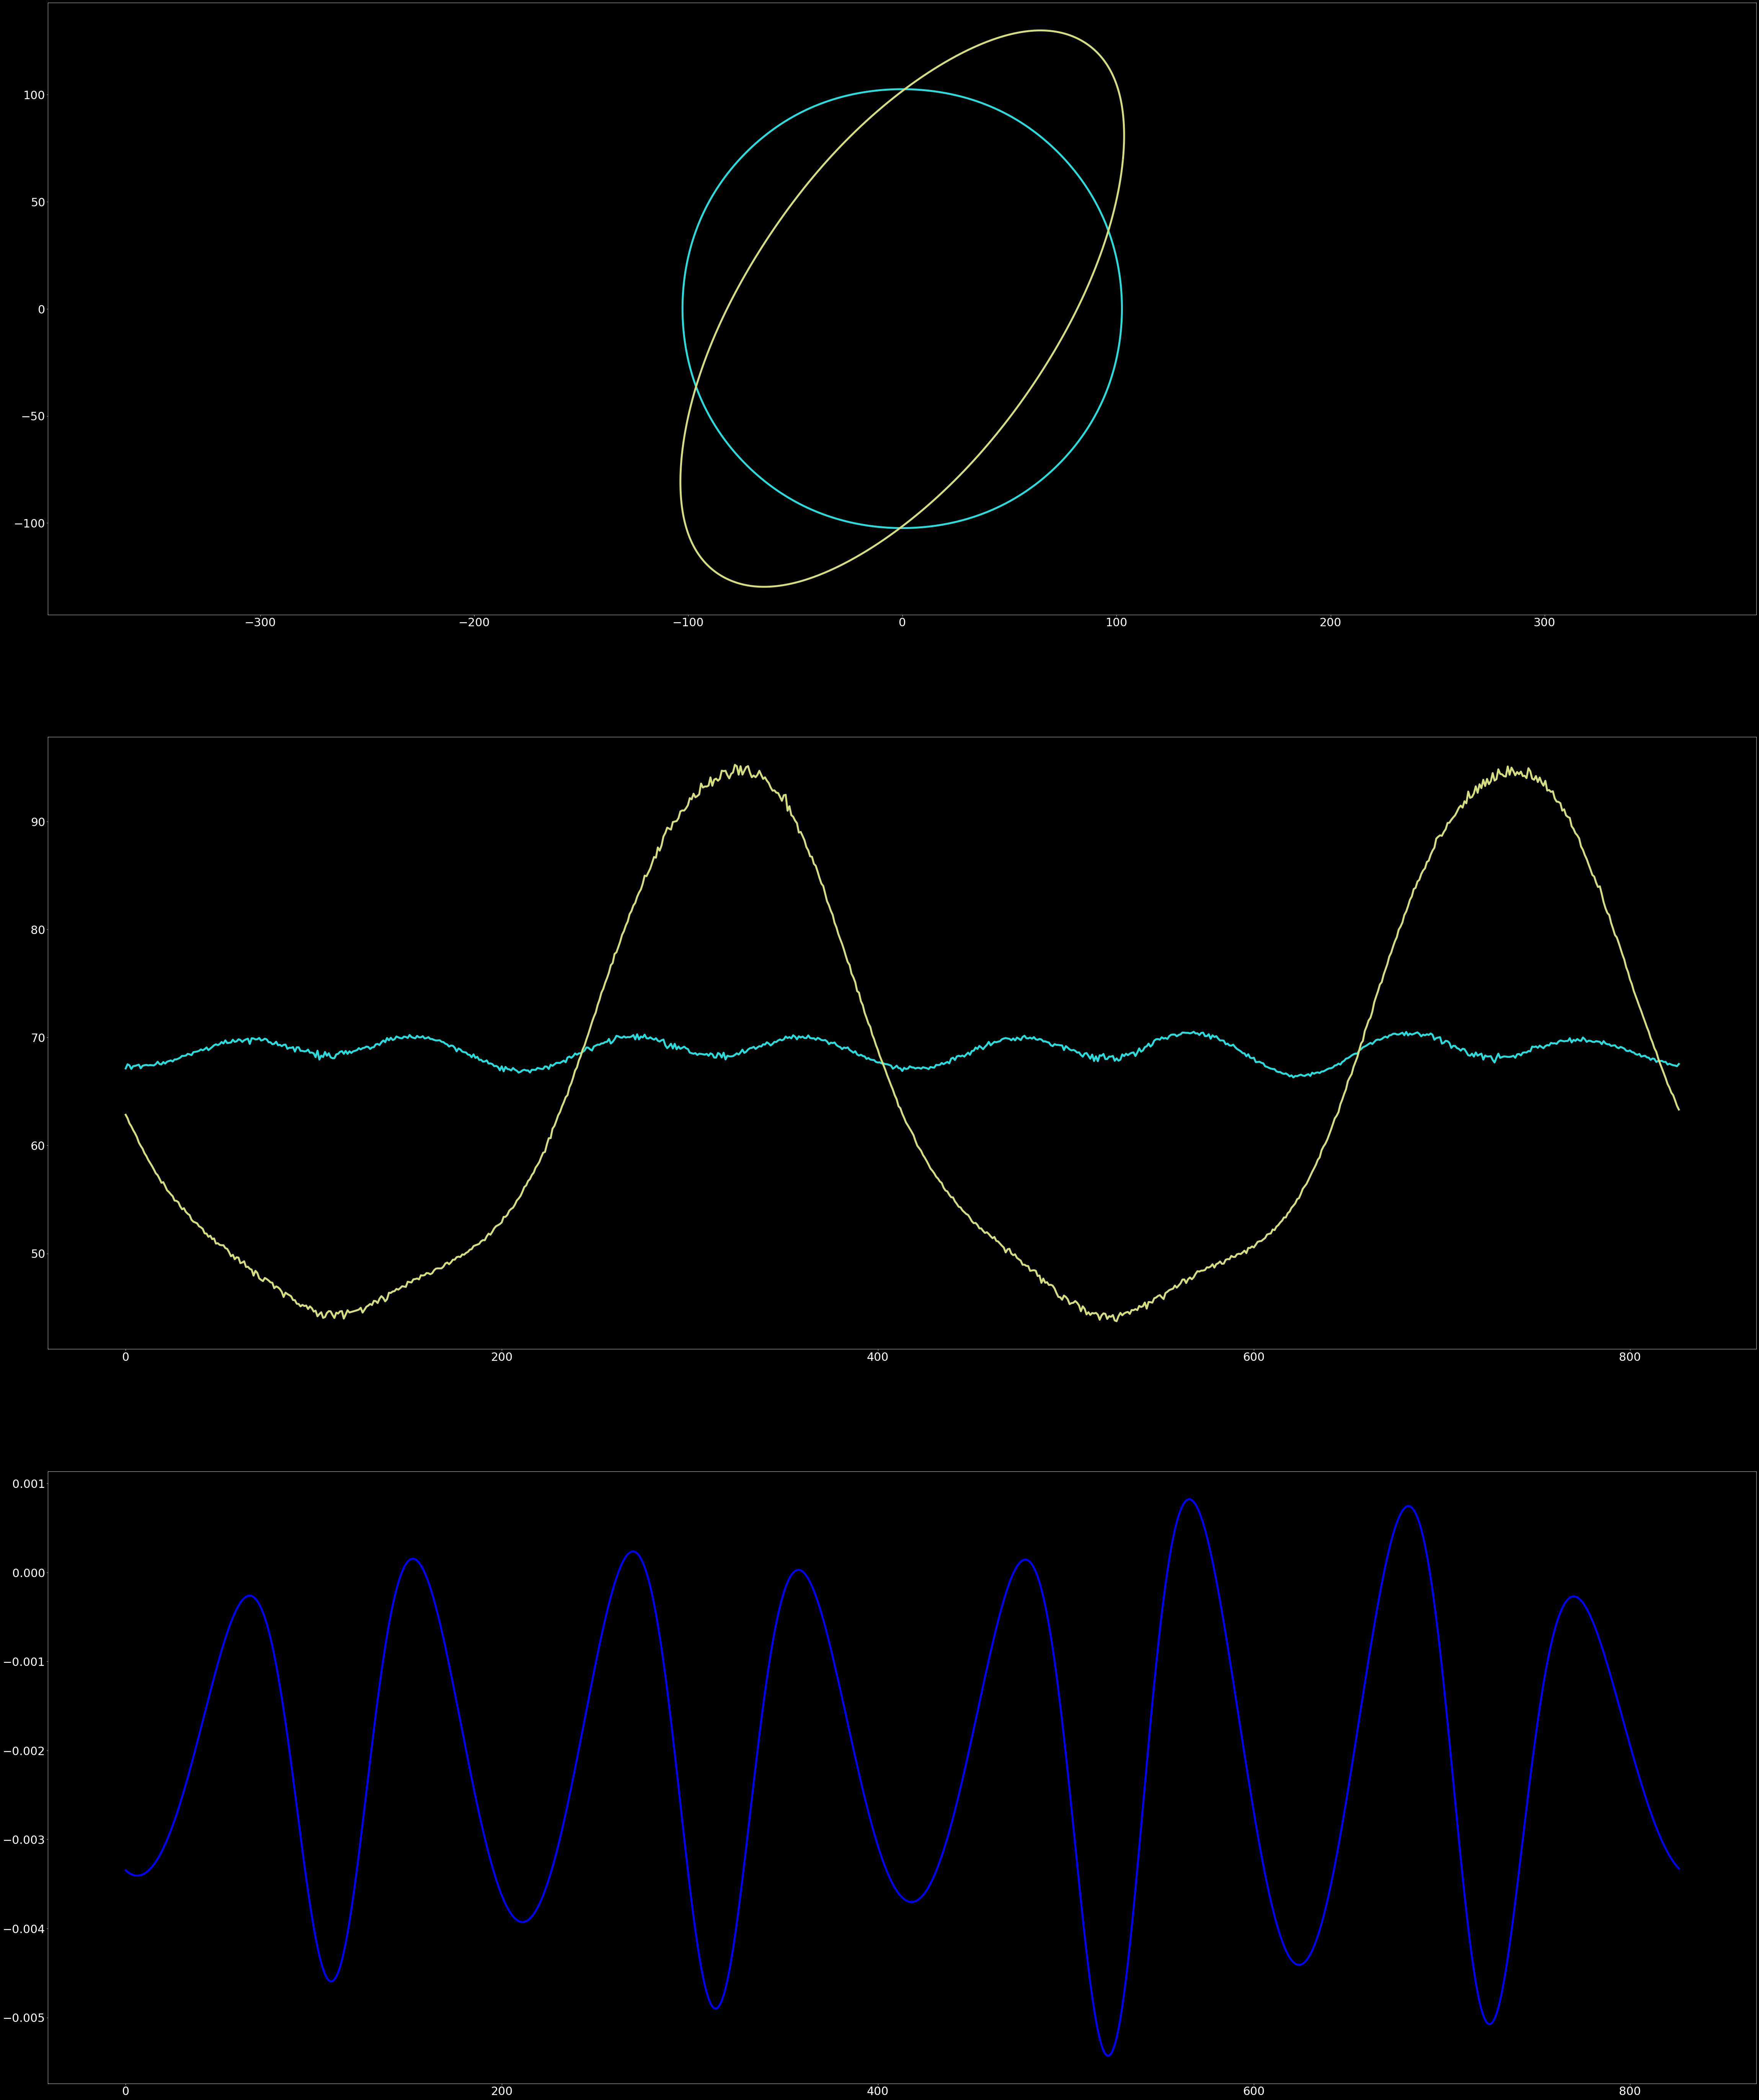

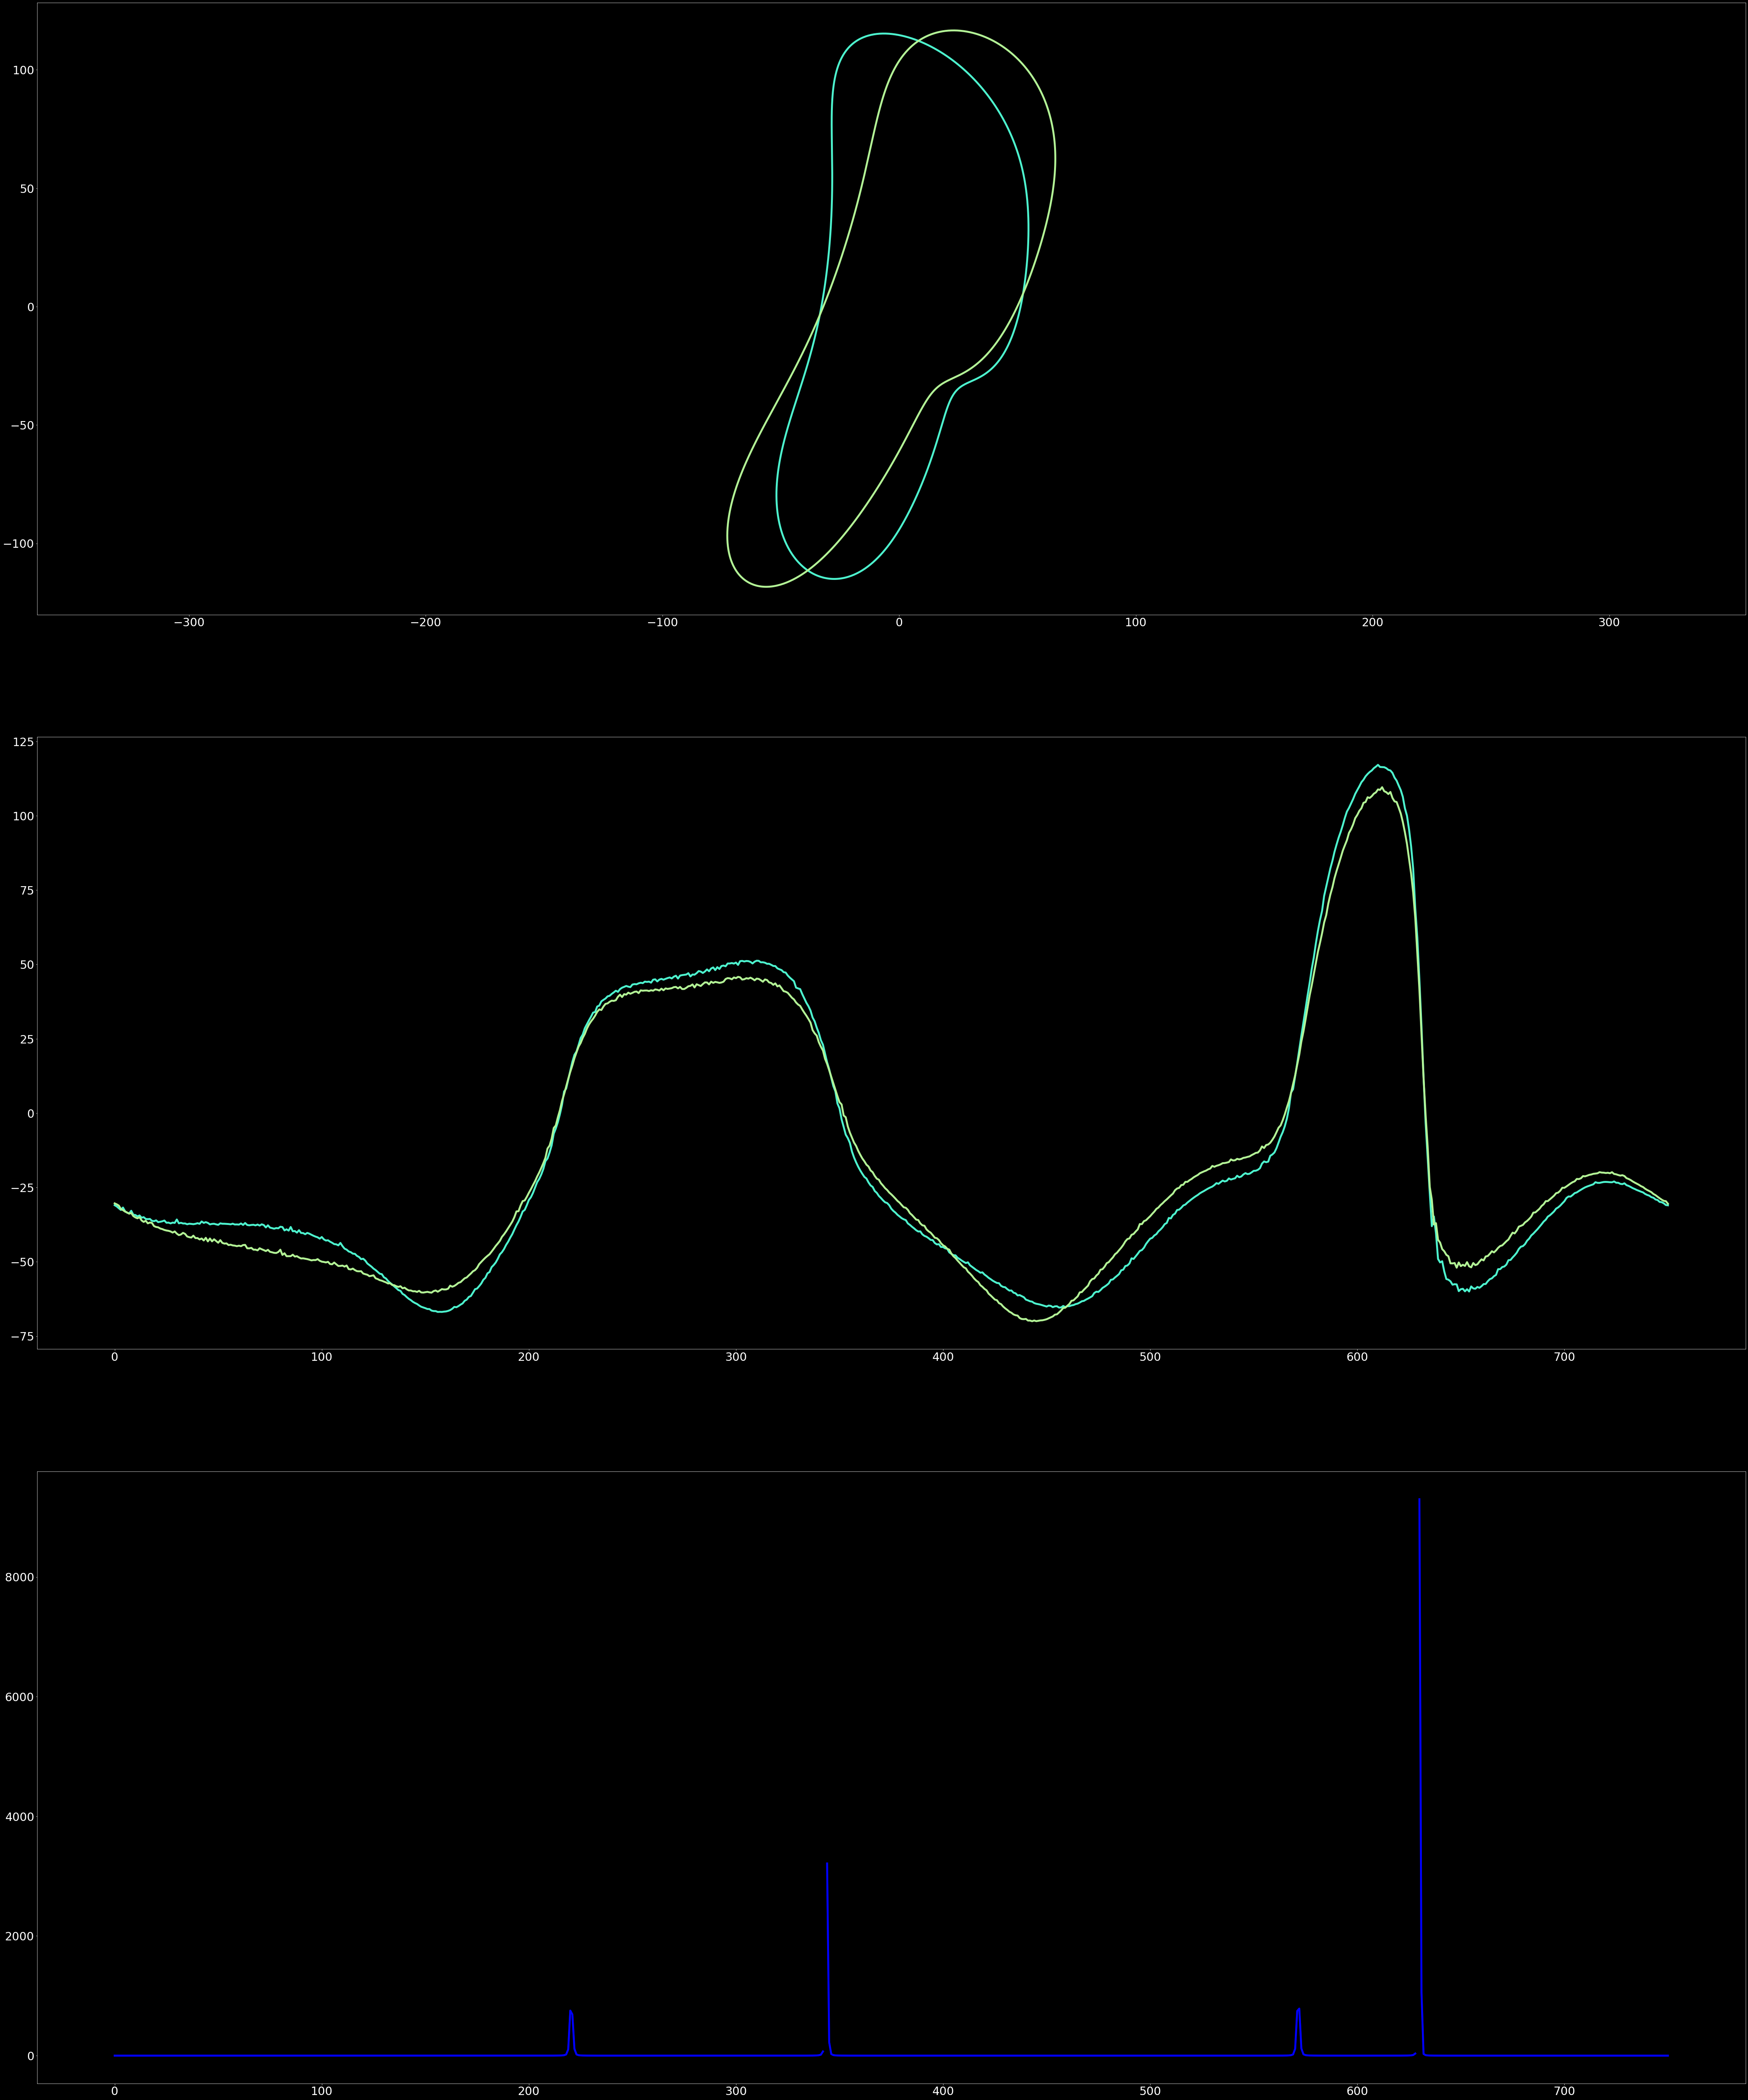

In [9]:
sample_points = 13
supporting_point_count = 6
max_offset = 7
limit = 8
numpy.random.seed(60)

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')
model = DeepSignatureCurvatureNet(sample_points=sample_points).cuda()
model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
model.eval()

curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
numpy.random.shuffle(curves)
curves = curves[:limit]
color_map = plt.get_cmap('rainbow', 2*limit)

for curve_index, curve in enumerate(curves):
    fig, ax = plt.subplots(3, 1, figsize=(80,100))
    ax[0].axis('equal')
    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        label.set_fontsize(30)

    for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(30)

    for label in (ax[2].get_xticklabels() + ax[2].get_yticklabels()):
        label.set_fontsize(30)

    # color-map indices
    color1_index = curve_index
    color2_index = 2*limit - curve_index - 1

    # print(numpy.mean(curve, axis=0))

    # transform curve
    if curvature_type == 'euclidean':
        transform = euclidean_transform.random_euclidean_transform_2d()
    elif curvature_type == 'affine':
        transform = affine_transform.random_equiaffine_transform_2d()

    transformed_curve = curve_processing.transform_curve(curve=curve, transform=transform)

    # plot curves
    notebook_utils.plot_curve(ax=ax[0], curve=curve_processing.translate_curve(curve=curve, offset=-numpy.mean(curve, axis=0)), color=color_map(color1_index), linewidth=5)
    notebook_utils.plot_curve(ax=ax[0], curve=curve_processing.translate_curve(curve=transformed_curve, offset=-numpy.mean(transformed_curve, axis=0)), color=color_map(color2_index), linewidth=5)

    # plot predicted curvature
    predicted_curvature1 = numpy.zeros(curve.shape[0])
    predicted_curvature2 = numpy.zeros(curve.shape[0])
    center_index = 1
    for i in range(curve.shape[0]):
        sample1 = curve_sampling.sample_curve_point_neighbourhood(
            curve=curve,
            center_point_index=i,
            supporting_point_count=supporting_point_count,
            max_offset=max_offset)

        sample2 = curve_sampling.sample_curve_point_neighbourhood(
            curve=transformed_curve,
            center_point_index=i,
            supporting_point_count=supporting_point_count,
            max_offset=max_offset)

        # orig_sample = sample.copy()

        sample1 = curve_processing.normalize_curve(curve=sample1)
        sample2 = curve_processing.normalize_curve(curve=sample2)
        # line1 = numpy.array([[1,1],[1.1,1.1],[1.2,1.2],[1.3,1.3],[1.4,1.4],[1.5,1.5],[1.6,1.6],[1.7,1.7],[1.8,1.8]]) * 1e-40
        # line1 = curve_processing.normalize_curve(curve=line1)
        # batch_data_line1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(line1).double(), dim=0), dim=0).cuda()
        # with torch.no_grad():
        #     zero_curvature = float(torch.squeeze(model(batch_data_line1), dim=0).cpu().detach().numpy())

        batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()
        with torch.no_grad():
            predicted_curvature1[i] = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()

        batch_data2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample2).double(), dim=0), dim=0).cuda()
        with torch.no_grad():
            predicted_curvature2[i] = torch.squeeze(model(batch_data2), dim=0).cpu().detach().numpy()

            # kappa = torch.squeeze(model(batch_data), dim=0).cpu().detach().numpy()
            # adj_kappa = kappa + zero_curvature
            # if curve_processing.is_ccw(curve=orig_sample):
            #     predicted_curvature[i] = -adj_kappa
            # else:
            #     predicted_curvature[i] = adj_kappa

    notebook_utils.plot_curvature(ax=ax[1], curvature=predicted_curvature1, color=color_map(color1_index), linewidth=5)
    notebook_utils.plot_curvature(ax=ax[1], curvature=predicted_curvature2, color=color_map(color2_index), linewidth=5)

    # plot ground-truth curvature
    if curvature_type == 'euclidean':
        gt_curvature1 = curve_processing.calculate_euclidean_curvature(curve=curve)
        gt_curvature2 = curve_processing.calculate_euclidean_curvature(curve=transformed_curve)
    elif curvature_type == 'affine':
        gt_curvature1 = curve_processing.calculate_affine_curvature(curve=curve)
        gt_curvature2 = curve_processing.calculate_affine_curvature(curve=transformed_curve)
    
    # gt_curvature = curve_processing.calculate_curvature(curve=curve)
    notebook_utils.plot_curvature(ax=ax[2], curvature=gt_curvature1, color='blue', linewidth=5)
    notebook_utils.plot_curvature(ax=ax[2], curvature=gt_curvature2, color='blue', linewidth=5, alpha=0.5)

    plt.show()